In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from itertools import product
from loguru import logger
from torch import Tensor
import numpy as np
from matplotlib.patches import FancyArrowPatch
from tqdm import tqdm
import torch.nn as nn

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
# It's also possible to use the reduced notation by directly setting font.family:
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

In [2]:
# utilities

def fill_ax(ax, feat_s, feat_i, feat_o, trajectory):
    """
    support : [?, 2]
    feat_i : [?, 2]
    feat_o : [?, 2]
    
    trajectory : [n_iter, 2]
    """
    ax.scatter(feat_s[:, 0], feat_s[:, 1], label='support')
    ax.scatter(feat_i[:, 0], feat_i[:, 1], label='in-distribution')
    ax.scatter(feat_o[:, 0], feat_o[:, 1], label='out-of-distribution')
    
    ax.scatter(trajectory[:, 0], trajectory[:, 1])
    
    for i, (x, y) in enumerate(trajectory):
        ax.annotate(i, (x + 0.05, y + 0.05))

In [3]:
def generate_trajectories(feat_s, feat_i, feat_o):
    """
    Generate multiple trajectories, for multiple initialization points.
    """
    raw_feat_i = feat_i
    raw_feat_o = feat_o
    
    n_iter = 100
    
    all_init = list(product([1, -1], repeat=2))
    trajectories = torch.empty(len(all_init), n_iter, 2)
    
    
    for i, initialization in enumerate(all_init):
        
        mu = torch.tensor(initialization).float().unsqueeze(0) # [1, 2]
        mu.requires_grad_()
        optimizer = torch.optim.SGD([mu], lr=0.1)
        d = raw_feat_i.size(-1)

        for j in range(n_iter):
            
            unorm_feat_i = raw_feat_i - mu
            feat_i = F.normalize(unorm_feat_i, dim=1)  # [?, d]

            feat_o = raw_feat_o - mu
            feat_o = F.normalize(feat_o, dim=1)  # [?, d]

            trajectories[i, j, :] = mu.detach().squeeze()

            sup = feat_s - mu
            sup = F.normalize(sup, dim=1)
            sup = sup.mean(0, keepdim=True)  # [1, d]

            loss = + (feat_o @ sup.t()).mean()  -  (feat_i @ sup.t()).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

#             logger.info(f"{i}: {loss.item()}")
        mu = mu.detach()
    return trajectories


## Plotting trajectories

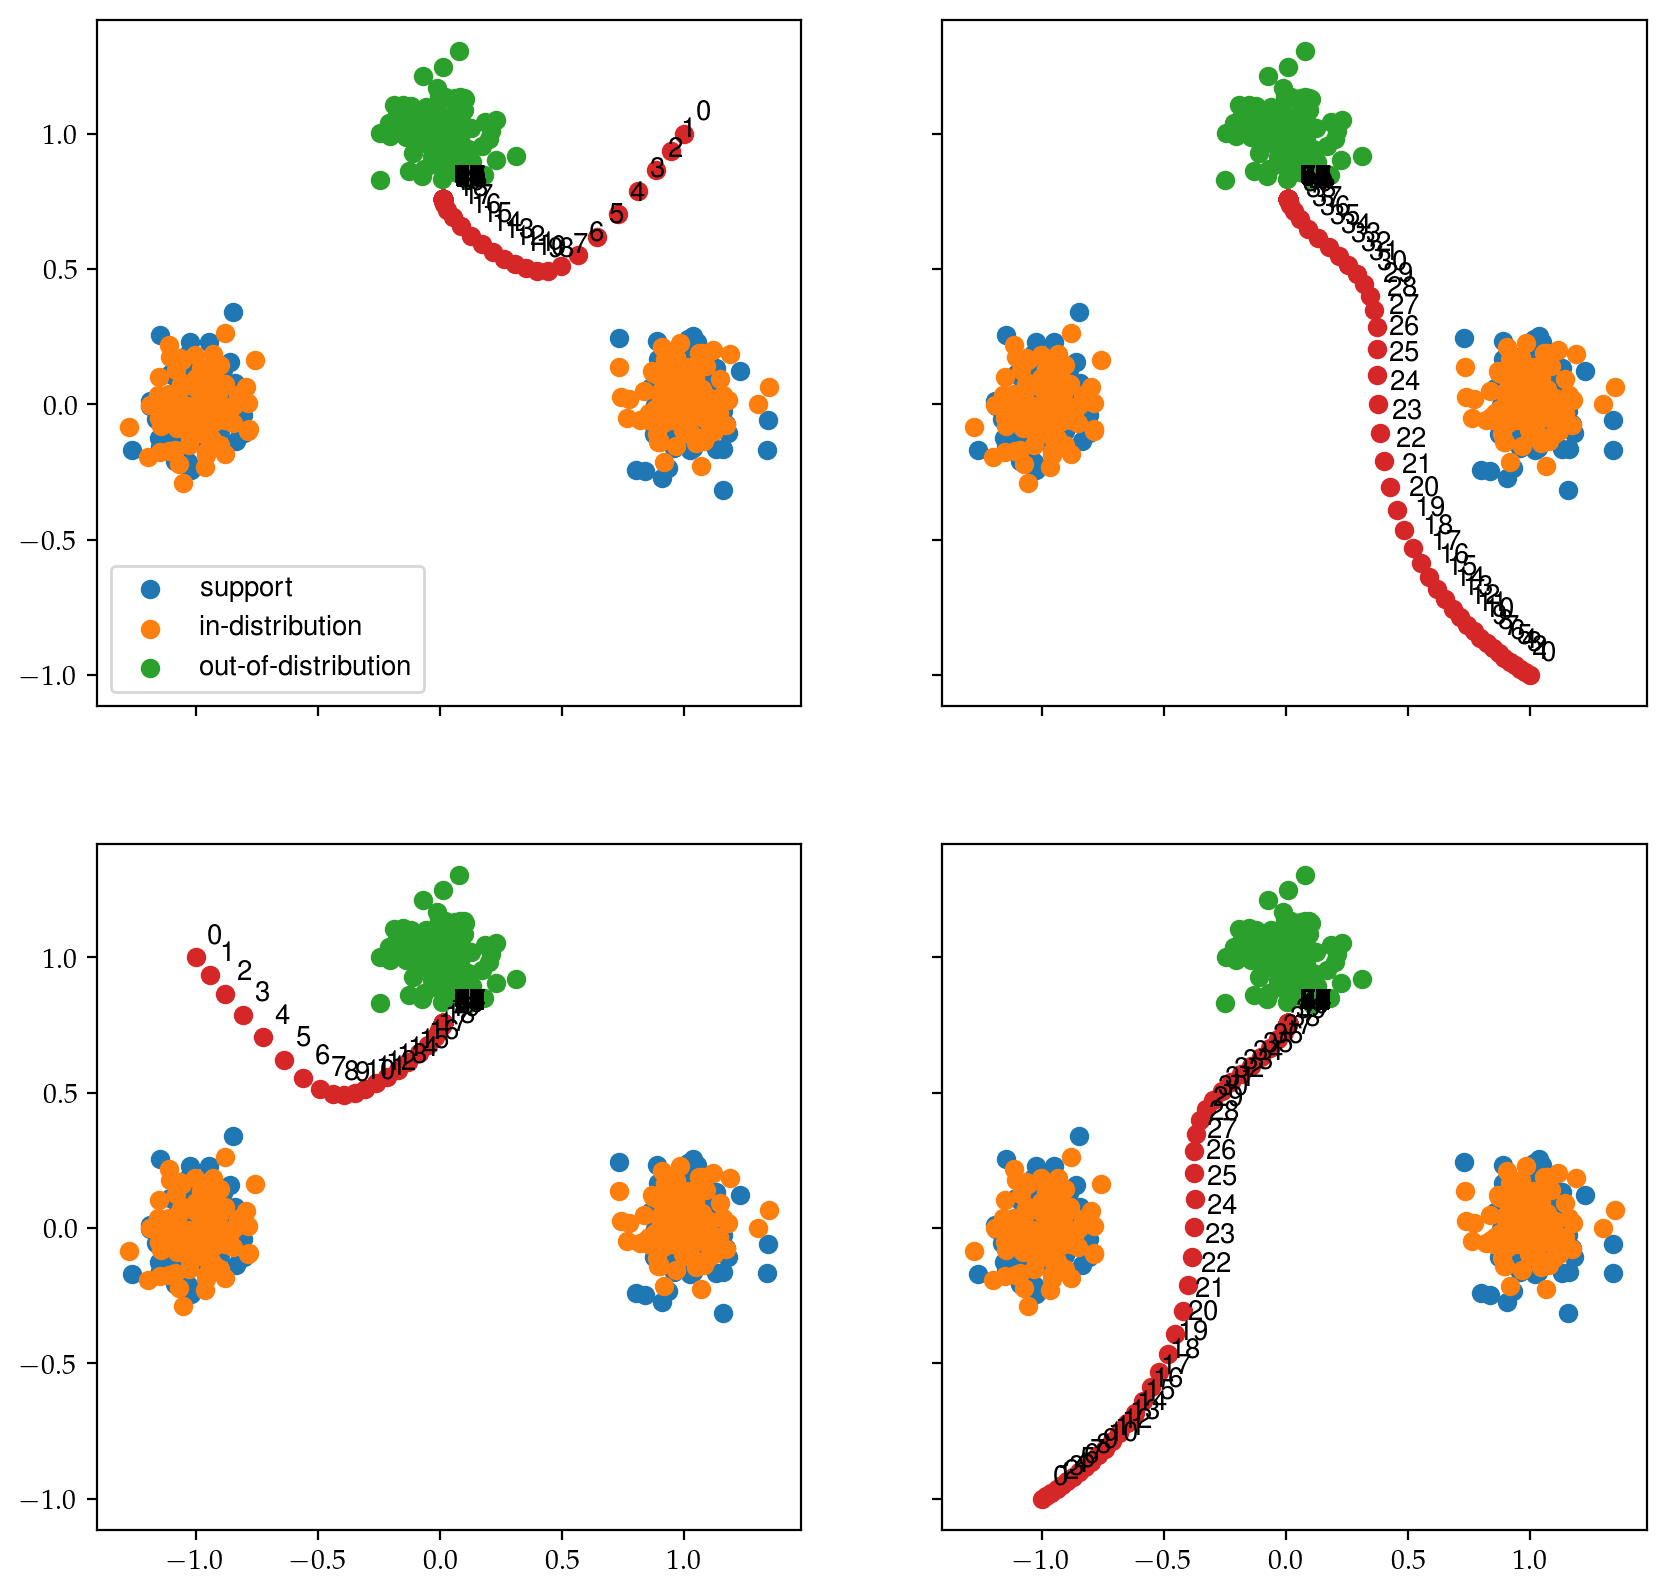

In [60]:
# Main
trajectories = generate_trajectories(feat_s, feat_i, feat_o) # [n_init, n_iter, 2]

f, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True, dpi=200)
for i, (ax, traj) in enumerate(zip(axes.flatten(), trajectories)):
    fill_ax(ax, feat_s, feat_i, feat_o, traj)
    if i==0:
        ax.legend()

# Plotting gradient field

In [30]:
# Generate data

def generate_data(id_centers, ood_centers, std = 0.1, n_samples_per_cluster = 200):
    
    torch.manual_seed(2)
    feat_s = []
    feat_i = []
    feat_o = []

    for center in id_centers:
        feat_s.append(torch.Tensor(center) + std * torch.randn(n_samples_per_cluster // 2, 2))
        feat_i.append(torch.Tensor(center) + std * torch.randn(n_samples_per_cluster // 2, 2))

    for center in ood_centers:
        feat_o.append(torch.Tensor(center) + std * torch.randn(n_samples_per_cluster, 2))

    feat_s = torch.cat(feat_s)
    feat_i = torch.cat(feat_i)
    feat_o = torch.cat(feat_o)
    
    return feat_s, feat_i, feat_o

In [31]:
def plot_contours(ax, feat_s, feat_i, feat_o):
    
    n_points = 30
    feature_x = np.linspace(-2, 2, n_points)
    feature_y = np.linspace(-1, 2, n_points)
    ax.set_aspect(1)
    
    ax.scatter(feat_s[:, 0], feat_s[:, 1], label='Support')
    ax.scatter(feat_i[:, 0], feat_i[:, 1], label='In-distribution samples')
    ax.scatter(feat_o[:, 0], feat_o[:, 1], label='Out-of-distribution samples')

    grid_x, grid_y = np.meshgrid(feature_x, feature_y)
    losses = np.zeros((n_points, n_points))

    # Plot gradient field and contours

    for i in range(n_points):
        for j in range(n_points):
            x, y = grid_x[i, j], grid_y[i, j]
            grad, loss = get_gradient_at(feat_s, feat_i, feat_o, torch.Tensor([x, y]))
            losses[i, j] = loss
            color = 'red' if grad.norm().item() < 0.05 else 'gray'
            grad = - 0.12 *  F.normalize(grad, dim=0)
            ax.quiver(x, y, grad[0], grad[1], units='xy', scale=0.9, color=color, width=0.01)

    # Showing point of minimum loss
    lowest_loss_index = np.where(losses == losses.min())
    lowest_x = grid_x[lowest_loss_index]
    lowest_y = grid_y[lowest_loss_index]

    ax.scatter(lowest_x, lowest_y, s=100.0, marker='x', label='Optima')

    ax.contour(grid_x, grid_y, losses, 10, cmap='jet', lw=2, levels=20)
#     ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
#               ncol=4, fancybox=True, shadow=True, prop={'size': 15})
    

In [36]:
def get_gradient_at(feat_s, feat_i, feat_o, mu_value):
    """
    mu_value: Tensor [2,]
    """
    raw_feat_i = feat_i
    raw_feat_o = feat_o
    
    min_fn = nn.Softmin(dim=-1)
    
    mu = Tensor(mu_value).float().unsqueeze(0) # [1, 2]
    mu.requires_grad_()
    
#     with torch.no_grad():

    feat_i = raw_feat_i - mu
    feat_i = F.normalize(feat_i, dim=1)  # [?, d]

    feat_o = raw_feat_o - mu
    feat_o = F.normalize(feat_o, dim=1)  # [?, d]

    feat_s = feat_s - mu
    feat_s = F.normalize(feat_s, dim=1) # [n_s, d]
#     sup = sup.mean(0, keepdim=True)  # [1, d]

#     loss = min_fn(feat_o @ feat_s.t()).sum(-1).mean()  - min_fn(feat_i @ feat_s.t()).sum(-1).mean()
    loss = (feat_o @ feat_s.t()).mean()  - (feat_i @ feat_s.t()).mean()
    
    loss.backward()

    return mu.grad.squeeze(), loss.item()

/tmp/ipykernel_4672/1159826496.py:33: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(grid_x, grid_y, losses, 10, cmap='jet', lw=2, levels=20)


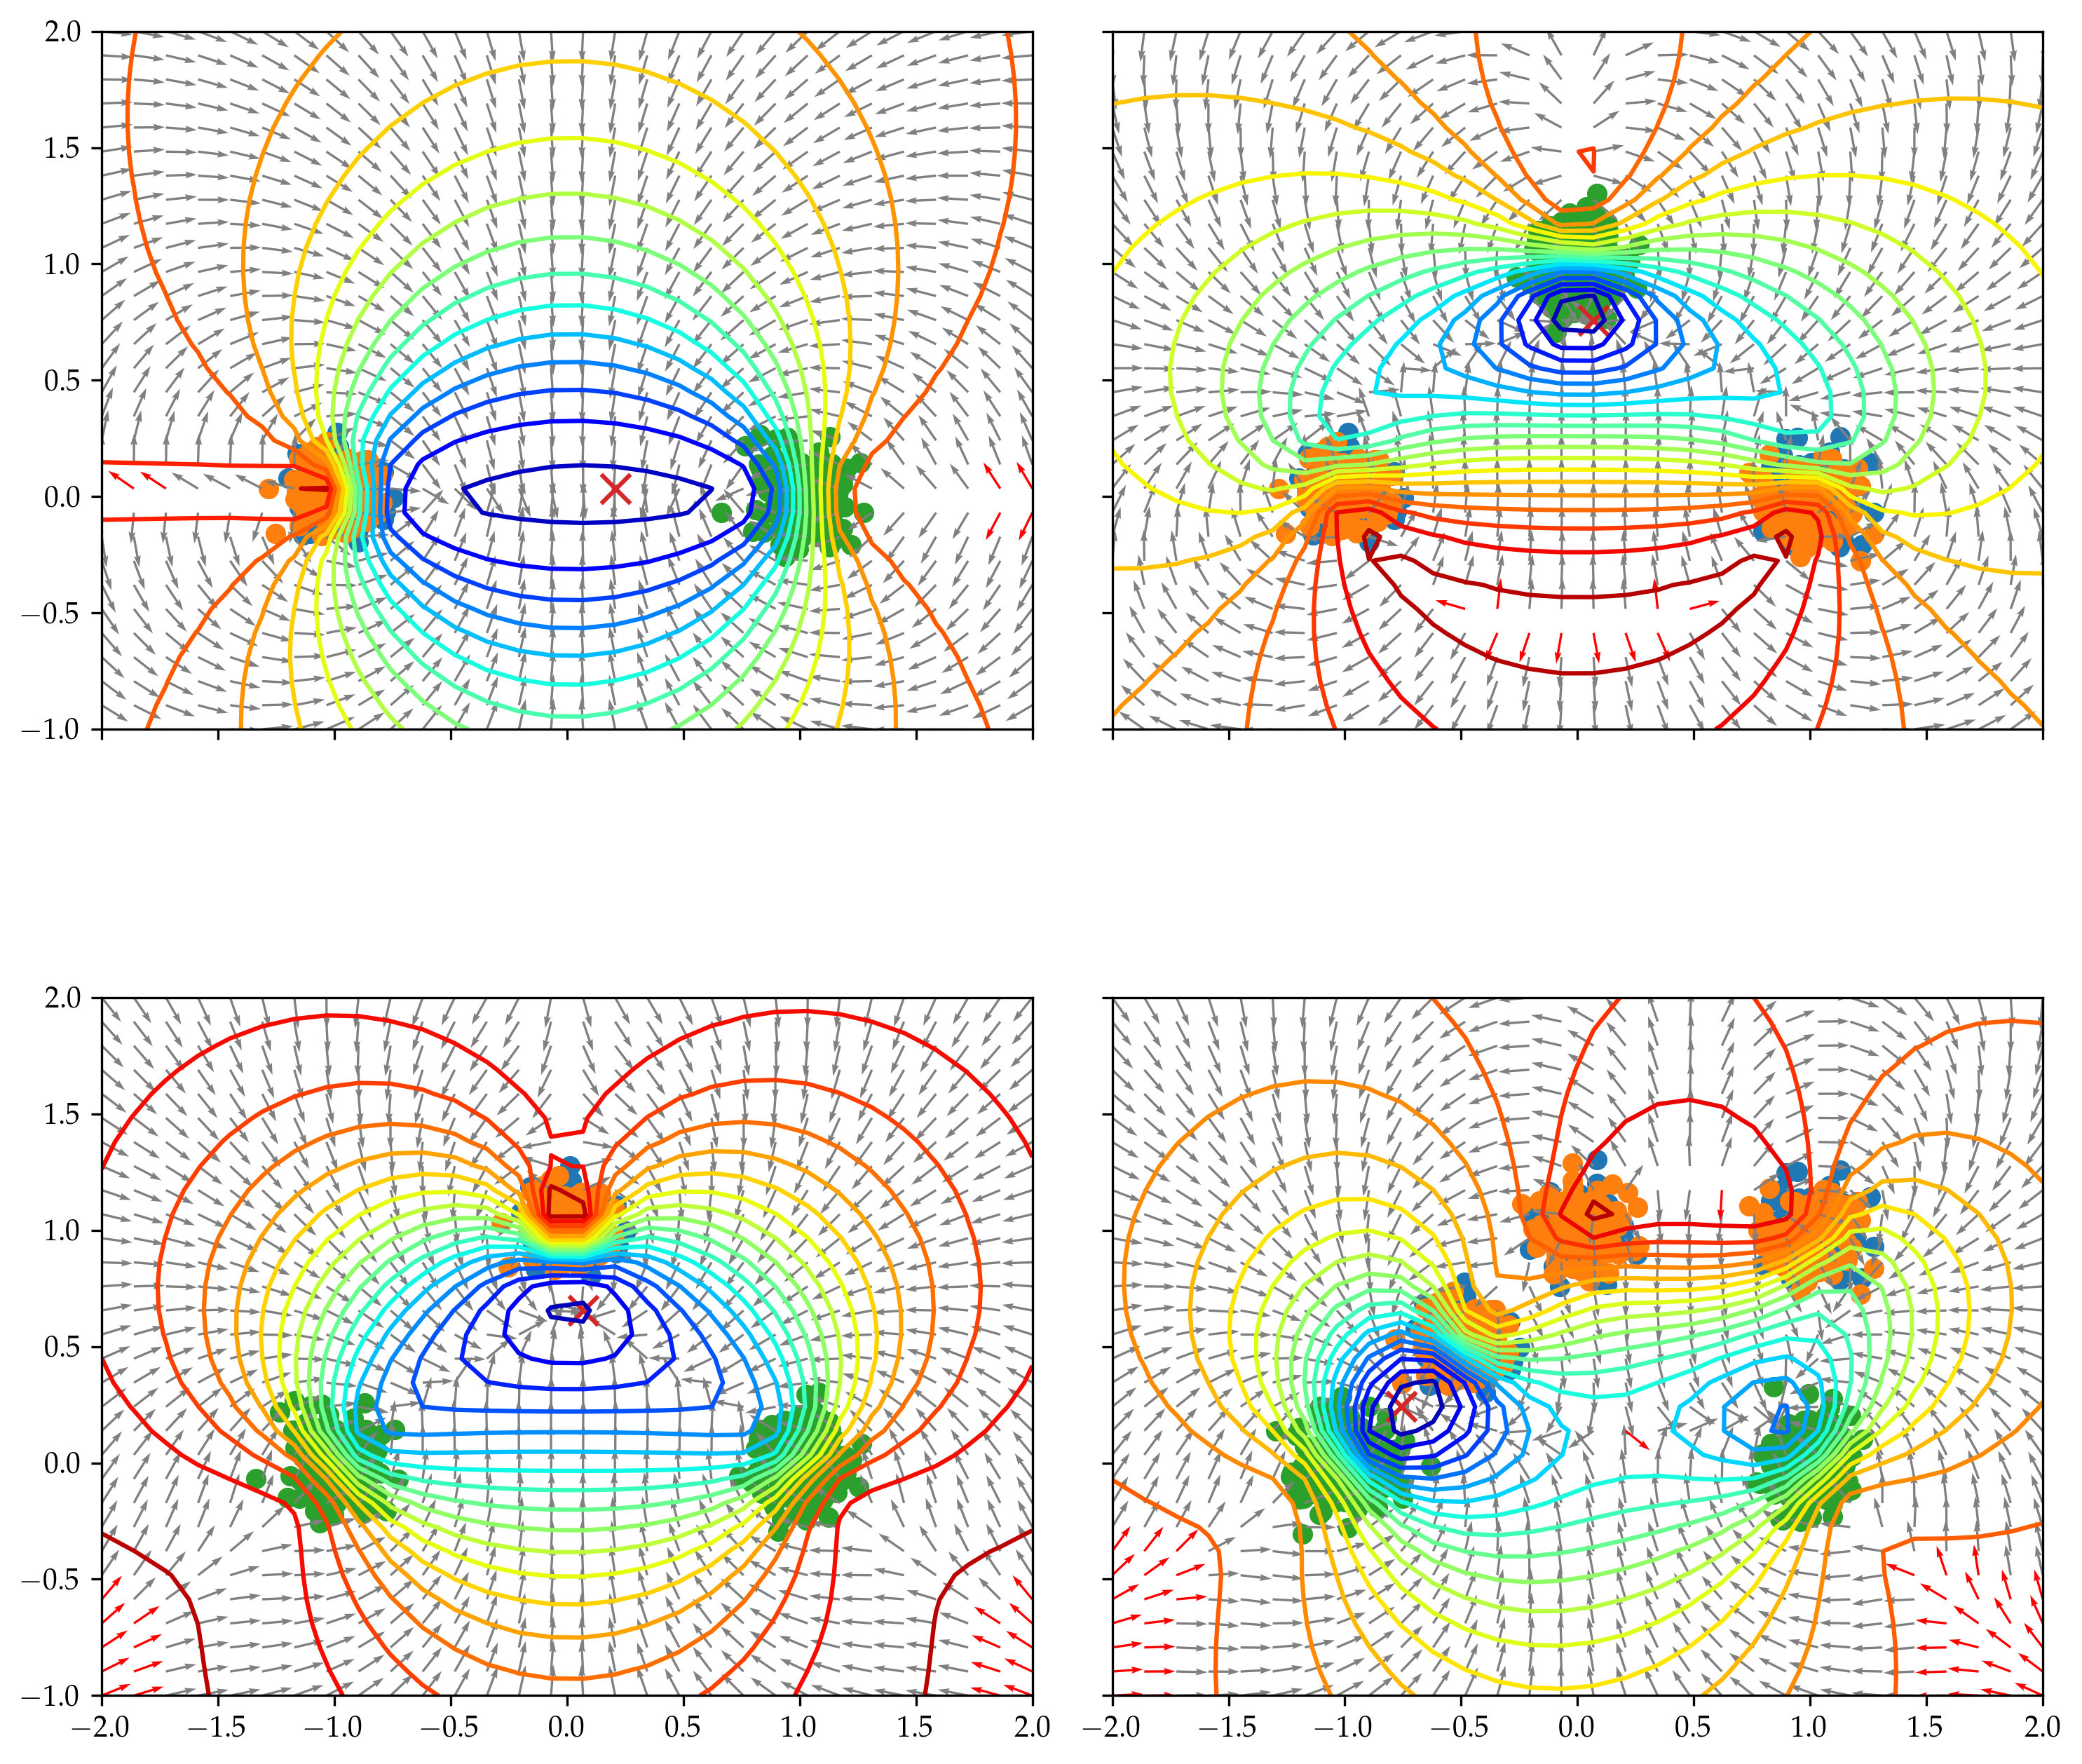

In [35]:
scenarios = {
    'Unimodal': {
                 'id_centers': [[-1,0]],
                 'ood_centers': [[1,0]]
                },
    
    'Unimodal-Bimodal': {
                          'id_centers': [[-1,0], [1, 0]],
                          'ood_centers': [[0, 1]]
                        },
    
    'Bimodal-Unimodal': {
                         'id_centers': [[0, 1]],
                         'ood_centers': [[-1,0], [1, 0]]
                        },
    
    'Bimodal-Bimodal': {
                        'id_centers': [[-0.5, 0.5], [1.0, 1.0], [0, 1.0]],
                         'ood_centers': [[-1,0], [1, 0]]
                       }
            }

f, axes = plt.subplots(len(scenarios) // 2, 2, figsize=(10, 10), sharey=True, sharex=True, dpi=300)
for scenario, ax in zip(scenarios.values(), axes.flatten()):
    feat_s, feat_i, feat_o = generate_data(scenario['id_centers'], scenario['ood_centers'])
    plot_contours(ax, feat_s, feat_i, feat_o)
f.tight_layout()
f.savefig('plots/contours.pdf')
